In [1]:
import datetime

import numpy as np
import tensorflow as tf
from tensorflow import keras
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from data import example_to_tensor
from train import EarlyStopping
from utils import plot_slice, plot_animated_volume

print(f"Tensorflow: {tf.__version__}")
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

%matplotlib inline
plt.rcParams["figure.figsize"] = [15, 7]

Tensorflow: 2.3.0


In [27]:
# Hyperparameters
epochs = 1000
learning_rate = 0.0001
patience = 3
batch_size = 2
xy_size = 128  # downscale 4
#z_size = 96  # downscale 4 (nrrd)
z_size = 244  # downscale 4 (tcia)
# xy_size = 256  # downscale 2
# z_size = 176  # downscale 2
# xy_size = 512   # original
# z_size = 368    # original

In [28]:
dataset = tf.data.TFRecordDataset("data/tcia-0.25-float16.tfrecords")
dataset = dataset.map(lambda x: example_to_tensor(x, "float16"))
dataset = dataset.padded_batch(
    batch_size=2, padded_shapes=[z_size, xy_size, xy_size, 1],
)
# dataset = dataset.skip(10)
dataset = dataset.take(2)
# dataset = dataset.shuffle(buffer_size=10, reshuffle_each_iteration=True)
dataset

<TakeDataset shapes: (None, 244, 128, 128, 1), types: tf.float16>

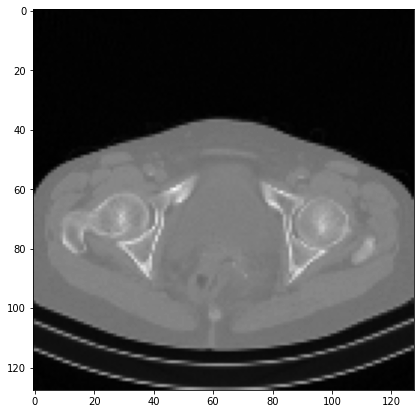

In [29]:
scan = next(iter(dataset))
plot_slice(scan, 0, 3)

In [46]:
encoder = keras.models.Sequential(
    [
        keras.layers.Conv3D(
            input_shape=[z_size, xy_size, xy_size, 1],
            filters=8,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
        keras.layers.Conv3D(
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.MaxPool3D(pool_size=2),
    ]
)
encoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_8 (Conv3D)            (None, 244, 128, 128, 8)  224       
_________________________________________________________________
activation_10 (Activation)   (None, 244, 128, 128, 8)  0         
_________________________________________________________________
alpha_dropout_8 (AlphaDropou (None, 244, 128, 128, 8)  0         
_________________________________________________________________
max_pooling3d_4 (MaxPooling3 (None, 122, 64, 64, 8)    0         
_________________________________________________________________
conv3d_9 (Conv3D)            (None, 122, 64, 64, 16)   3472      
_________________________________________________________________
activation_11 (Activation)   (None, 122, 64, 64, 16)   0         
_________________________________________________________________
alpha_dropout_9 (AlphaDropou (None, 122, 64, 64, 16)  

In [47]:
decoder = keras.models.Sequential(
    [
        keras.layers.UpSampling3D(
            input_shape=encoder.layers[-1].output.shape[1:], size=2,
        ),
        keras.layers.Conv3D(
            filters=16,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.UpSampling3D(size=2,),
        keras.layers.Conv3D(
            filters=8,
            kernel_size=3,
            padding="same",
            kernel_initializer="lecun_normal",
            bias_initializer="lecun_normal",
        ),
        keras.layers.Activation("selu"),
        keras.layers.AlphaDropout(0.25),
        keras.layers.Dense(1),
        keras.layers.Activation("sigmoid"),
    ]
)
decoder.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
up_sampling3d_4 (UpSampling3 (None, 122, 64, 64, 16)   0         
_________________________________________________________________
conv3d_10 (Conv3D)           (None, 122, 64, 64, 16)   6928      
_________________________________________________________________
activation_12 (Activation)   (None, 122, 64, 64, 16)   0         
_________________________________________________________________
alpha_dropout_10 (AlphaDropo (None, 122, 64, 64, 16)   0         
_________________________________________________________________
up_sampling3d_5 (UpSampling3 (None, 244, 128, 128, 16) 0         
_________________________________________________________________
conv3d_11 (Conv3D)           (None, 244, 128, 128, 8)  3464      
_________________________________________________________________
activation_13 (Activation)   (None, 244, 128, 128, 8) 

In [48]:
autoencoder = keras.models.Sequential([encoder, decoder])
# autoencoder.load_weights("models/autoencoder/20200723-103317/best_epoch_ckpt")
# autoencoder = keras.models.load_model("../../20200816-170759/")
autoencoder.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_6 (Sequential)    (None, 61, 32, 32, 16)    3696      
_________________________________________________________________
sequential_7 (Sequential)    (None, 244, 128, 128, 1)  10401     
Total params: 14,097
Trainable params: 14,097
Non-trainable params: 0
_________________________________________________________________


In [49]:
loss_fn = keras.losses.MeanSquaredError()
optimizer = keras.optimizers.Adam(lr=learning_rate)

In [50]:
current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f"logs/autoencoder/{current_time}/"
model_dir = f"models/autoencoder/{current_time}/"
ckpt_dir = model_dir + "best_epoch_ckpt"
writer = tf.summary.create_file_writer(log_dir)
train_loss = tf.keras.metrics.Mean("train_loss", dtype=tf.float32)
early_stopping = EarlyStopping(patience)

for epoch in tqdm(range(epochs), disable=False):
    for batch_features in tqdm(dataset, total=1, disable=True):
        with tf.GradientTape() as tape:
            predictions = autoencoder(batch_features)
            loss_value = loss_fn(predictions, batch_features)
        gradients = tape.gradient(loss_value, autoencoder.trainable_variables)
        optimizer.apply_gradients(zip(gradients, autoencoder.trainable_variables))
        with writer.as_default():
            for grad, param in zip(gradients, autoencoder.trainable_variables):
                tf.summary.histogram(param.name, param, step=epoch)
                # tf.summary.histogram(param.name + "/grad", grad, buckets=1, step=epoch)
            train_loss(loss_value)

    with writer.as_default():
        loss_mean = train_loss.result()
        print(f"Training loss: {loss_mean}")
        tf.summary.scalar("loss", loss_mean, step=epoch)

    train_loss.reset_states()

    early_stopping(loss_mean)
    if early_stopping.early_stop:
        autoencoder.load_weights(ckpt_dir)
        autoencoder.save(model_dir)
        break
    elif early_stopping.counter == 0:
        autoencoder.save_weights(ckpt_dir)
else:
    # didn't stop for early stopping
    autoencoder.save(model_dir)

with writer.as_default():
    tf.summary.text(
        "Hyperparameters",
        f"batch size = {batch_size}; "
        f"patience = {patience}; "
        f"learning rate = {learning_rate}",
        step=0,
    )

Training loss: 0.396240234375
saving...
Training loss: 0.25115966796875
saving...
Training loss: 0.14056396484375
saving...
Training loss: 0.072296142578125
saving...
Training loss: 0.03643035888671875
saving...
Training loss: 0.019866943359375
saving...
Training loss: 0.012836456298828125
saving...
Training loss: 0.009765625
saving...
Training loss: 0.008388519287109375
saving...
Training loss: 0.0077228546142578125
saving...
Training loss: 0.0073070526123046875
saving...
Training loss: 0.00693511962890625
saving...
Training loss: 0.006534576416015625
saving...
Training loss: 0.0060977935791015625
saving...
Training loss: 0.00565338134765625
saving...
Training loss: 0.0052356719970703125
saving...
Training loss: 0.0048809051513671875
saving...
Training loss: 0.0046024322509765625
saving...
Training loss: 0.004403114318847656
saving...
Training loss: 0.004276275634765625
saving...
Training loss: 0.004210472106933594
saving...
Training loss: 0.0041866302490234375
saving...
Training loss

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=logs --bind_all

In [43]:
for i in dataset:
    print("hey")

hey
hey


In [45]:
scan1 = next(iter(dataset))
prediction1 = autoencoder(scan1)
l = loss_fn(scan1, prediction1)
scan2 = next(iter(dataset))
prediction2 = autoencoder(scan2)
l += loss_fn(scan2, prediction2)
print(l / 2)
#plot_slice(prediction, 0, 5)
#plt.imshow(prediction[0, 4, :, :, 0], cmap="gray")
#plot_animated_volume(prediction)

tf.Tensor(0.006463809, shape=(), dtype=float32)


In [ ]:
i = next(iter(dataset))
fig, ax = plt.subplots(ncols=3)
sample = 1
ax[0].imshow(tf.cast(i[sample, 0, :, :, 0], tf.float32), cmap="gray")
encoder_out = autoencoder.layers[0](i)
ax[1].imshow(tf.cast(encoder_out[sample, 0, :, :, 0], tf.float32), cmap="gray")
decoder_out = autoencoder.layers[1](encoder_out)
ax[2].imshow(tf.cast(decoder_out[sample, 0, :, :, 0], tf.float32), cmap="gray")